In [2]:
# Importing all needed libaries
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual,HBox, Label
import ipywidgets as widgets
from scipy.integrate import odeint as ode
import matplotlib.pyplot as plt
import numpy as np
import math

In [143]:
"""
Variables
"""
g = 32.174 #ft/s^2

W_max = 1030500 # lb
rho_sl = 0.002377693 #slug/ft^3
K = 0.055579171
C_L_max = 5 #2.7198
h_obstacle = 50 #ft
T_max = 388000 # take off thrust
T_cont = 332400 # maximum cont. thrust
mu = 0.05 #rolling resistance
C_D0 = 0.015 #historical
S_ref = 6891.60 #ft^2
C_L_min = 2
rho_cruise = 0.000891 #slug/ft^3 -> 30,000 ft
C = 2.805*2.20462 # lb/s -> thrust specific fuel consumption
cruise_alt = 30000 #ft
mach_max = 0.75 # maximum mach number
cruise_c = 990 #speed of sound at cruise
V_min = 370*1.68781 #ft/s
n=1.2 
step_size=0.01

In [185]:
"""
Functions
"""

def stall_vel(W, S,rho, C_L):
    return np.sqrt( (2*W) / (rho*S*C_L) )

def Lift(rho, V, C_L, S):
    return 1/2 * rho * C_L * S * V**2

def Drag(rho, V, S, C_D0, K, C_L):
    return 1/2*rho*V**2* S * (C_D0 + K*C_L**2)





### GROUND ROLL
def ground_accel(W, T, D, L, mu):
    return g / W * (T - D - mu*(W - L) )

def ground_dist(T, W, S, mu, rho, C_L, C_D0, K, V_I, V_F):
    
    K_T = (T / W) - mu
    K_A = (rho * ( mu*C_L - C_D0 - K*C_L**2 ) ) / ( 2 * ( W / S ) )
    
    log_factor = K_T + K_A*V_F**2
    
    return (1 / (2*g*K_A) )*np.log(log_factor / (K_T + K_A*V_I**2) ), K_T, K_A

# Transition
def Gamma(T, D, W):
    return math.asin( (T - D) / W )



### Steady, Level Flight. Cruise.

# Eq 17.10 Raymer
# Use this to determine optimal Cruise altitude
def cruise_vel(rho, C_L, W, S):
    return np.sqrt( (2 * W) / (rho*C_L * S))

def thrust_to_weight(q, C_D0, W, S, K):
    return q*C_D0 / (W / S) + (W / S) * (K / q)

def W_dot(C, T):
    return -C*T


## Fuel Required:
# C * T at the different stages of flight.
# make sure range requirement is met.




In [186]:
def Take_Off(T, W, S, mu, rho, C_L, C_D0, K, n=1.2):
    
    V_stall = stall_vel(W, S, rho, C_L)
    V_to = 1.1*V_stall
    V_trans = 1.15*V_stall
    D_to = 1/2*rho*V_to**2* (C_D0 + K*C_L**2)
    
    S_G, K_T, K_A = ground_dist(T, W, S, mu, rho, C_L, C_D0, K, 0, V_to)
    S_R = 3*V_to
    
    R_trans = V_trans**2 / (g * (n - 1))

    gamma_climb = np.arcsin( (T - D_to) / W )

    h_TR = R_trans*(1 - np.arccos(gamma_climb))

    if h_TR.any() > h_obstacle:
        S_TR = np.sqrt(R_trans**2 - (R_trans - h_obstacle)**2)
    else:
        S_TR = R_trans*np.arcsin(gamma_climb)


    takeoff_distance = S_G + S_R + S_TR
    
    return takeoff_distance, S_G, S_R, S_TR, h_TR, gamma_climb, V_stall, V_to, V_trans, K_T, K_A




def Take_Off_Interact(C_L_max, engine_num, W, S):
    
    T = T_max *engine_num/4

    C_L_array = np.arange(C_L_min, C_L_max+step_size, step_size)
    
    plt.figure(figsize=(8,7))
    plt.plot(C_L_array, Take_Off(T, W, S, mu, rho_sl, C_L_array, C_D0, K)[0], label='Total Distance')
    plt.plot(C_L_array, Take_Off(T, W, S, mu, rho_sl, C_L_array, C_D0, K)[1], label='Ground Roll', color='b')
    plt.plot(C_L_array, Take_Off(T, W, S, mu, rho_sl, C_L_array, C_D0, K)[3], label='Transition Distance', color='purple')
    plt.plot(C_L_array, Take_Off(T, W, S, mu, rho_sl, C_L_array, C_D0, K)[2], label='Rotation Ground Roll Distance',color='black')
    plt.xlabel('$C_L (-)$')
    plt.ylabel('Take-off Distance (ft)')
    plt.grid()
    plt.legend()
    #plt.plot(C_L_array, np.ones(len(C_L_array))*7000)
    plt.axhline(y=7000,color='r',linestyle='--')
    plt.annotate('7000 ft',[0.5, 7300])
    
    plt.figure(figsize=(8,7))
    plt.plot(C_L_array, Take_Off(T, W, S, mu, rho_sl, C_L_array, C_D0, K)[7], color='r')
    plt.xlabel('$C_L$ (-)')
    plt.ylabel('Take-Off Velocity (ft/sec)')
    plt.grid()
    
    plt.figure(figsize=(7,6))
    plt.plot(C_L_array, np.degrees(Take_Off(T, W, S, mu, rho_sl, C_L_array, C_D0, K)[5]), color='r')
    plt.xlabel('$C_L$ (-)')
    plt.ylabel('Climb Angle (deg)')
    plt.grid()

    return None




max V:  439.91918521634545
max range:  0.16731091041483429 nmi / lb
velocity for max range:  6992.534660504799 kts
Fuel Required:  34426.92401660197  lb
Lift Array:  [1021587.55556667 1021620.2733436  1021652.99164443 ... 1444128.70722842
 1444167.60711975 1444206.50753498]
Drag Array:  [61636.45451462 61638.42850868 61640.40253435 ... 87130.04861043
 87132.39559613 87134.74261344]
1030500
332400
2.0459727777777776


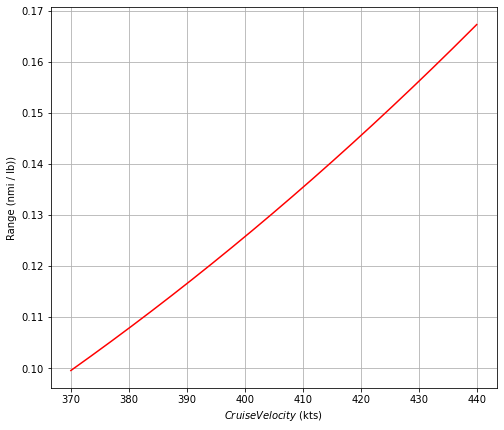

In [188]:
# Equation 17.3 Raymer
def Endurance(L, D, C, W_i, W_f):
    return (L / D) * (1 / C) * np.log(W_i / W_f)


# C = lb/s
# V = ft/s
# V/C = ft/lb
# Equation  17.23, Raymer
def Range(L, D, C, W_i, W_f, V):
    return Endurance(L,D,C,W_i,W_f) * V


### best range equations
def Range_Parameters(W, S):
    
    V = np.sqrt((2*W)/(rho_cruise*S) * np.sqrt(3*K / C_D0))
    D = 1/2 * rho_cruise * V**2 * S * (4/3 * C_D0)
    C_L = np.sqrt(C_D0 / (3*K))
    
    return V, D, C_L


# M = V/C, -> V = M*C
V_max = cruise_c * mach_max


range_req = 4800 # nmi

print('max V: ',V_max / 1.68781)


def Range_Interact(W_max, C_L, S, T):
    """
    W_max = maximum weight
    V = cruise velocity
    C_L = coefficient of lift at zero AoA
    S = wing span (no flaps)
    T = thrust
    """
    
    W_i = W_max
    W_f = W_max*0.6


    
    
    V_array = np.arange(V_min, V_max+step_size, step_size)
    range_array = np.zeros_like(V_array)
    L_array = np.zeros_like(V_array)
    D_array = np.zeros_like(V_array)
    
    for i in range(len(V_array)):
        L_array[i] = Lift(rho_cruise, V_array[i], C_L, S)
        D_array[i] = Drag(rho_cruise, V_array[i], S, C_D0, K, C_L)
        range_array[i] = Range(L_array[i], T, C, W_i, W_f, V_array[i])

    
    max_range = np.max(range_array)
    V_max_range = np.where(range_array == max_range)[0][0]
    
    
    
    min_fuel = 1.2 * range_req / (max_range*0.000164579) 
    
    
        
    plt.figure(figsize=(8,7))
    plt.plot(V_array /1.68781, range_array*0.000164579, color='r')
    plt.xlabel('$Cruise Velocity $ (kts)')
    plt.ylabel('Range (nmi / lb))')
    plt.grid()
    
    print('max range: ',max_range*0.000164579, 'nmi / lb')
    print('velocity for max range: ',V_max_range / 1.6878, 'kts')
    print('Fuel Required: ',min_fuel, ' lb')
    
    print('Lift Array: ',L_array)
    print('Drag Array: ',D_array)
    
    return range_array, max_range, V_max_range

C_L = 0.7
Range_Interact(W_max, C_L, 8400, 87134)
print(W_max)
print(T_cont)

CC = 0.478*(61636/4) / 3600
print(CC)

In [195]:
### Loiter Endurance

# Optimal velocity, is the velocity that minimises thrust/drag.

def loiter_vel(W, S, rho):
    return np.sqrt((2*W)/(rho*S)*np.sqrt(K/C_D0) )

V_loiter = loiter_vel(W_max*0.7, S_ref, 17.56e-4)

def min_drag(V, S):
    return C_D0 * rho_cruise * V**2

V_cruise_min = stall_vel(W_max*0.7, S_ref,17.56e-4, 0.7)
D_min = min_drag(V_loiter, S_ref)

print(V_loiter / 1.6878)
print(D_min)
print(V_cruise_min / 1.6878)

283.82454336738414
3.066979151743239
244.50949371224883


In [201]:
## Climb Optimisation

def climb_vel(W, S, T, rho):
    TW = T / W #thrust to weight ratio
    
    return np.sqrt( W / (S*3*rho*C_D0) * (TW + np.sqrt(TW)**2 + 12*C_D0*K) )

V_climb = climb_vel(W_max*0.95, S_ref, T_cont, rho_cruise)

print(V_climb)

1562.4857617126704


In [200]:
style = {'description_width': 'initial'}
interact_manual(Take_Off_Interact,
                C_L_max=widgets.FloatSlider(min=C_L_min+0.5, max=C_L_max,step=0.1,value=((C_L_min+C_L_max)/2),description='$C_{L_{max}}$',style=style),
                engine_num=widgets.IntSlider(min=1, max=4,step=1,value=3, description= 'Engine Number',style=style),
                W=widgets.FloatSlider(min=500000, max=1500000, step =100, value=W_max, description ='Take-Off Weight (lb)',style=style),
                S=widgets.FloatSlider(min=1000, max=15000, step =10, value=S_ref, description ='Wing Area ($ft^2$)',style=style),
               )

interactive(children=(FloatSlider(value=3.5, description='$C_{L_{max}}$', max=5.0, min=2.5, style=SliderStyle(…

<function __main__.Take_Off_Interact(C_L_max, engine_num, W, S)>